In [1]:
import numpy as np
import pandas as pd
import json
import argparse
import geopandas
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from pointpats import random
from shapely import geometry
from itertools import combinations
from utils import *
from geo_utils import *
from models import *

In [3]:
print('Load Parameters...')
with open('config.json') as json_file:
    parameters = json.load(json_file)

## load data
low_res_name = 'block'
super_res_name = 'extreme'
training_portion = 1
hops = parameters['hops']
batch_size = parameters['batch_size']
device = "cuda" if torch.cuda.is_available() else "cpu"

parameters['index'] = 2399
parameters['training_portion'] = training_portion
parameters['zones'] = [12,88,87,261,13,209,45,231,232,148,144,211,125,158,249,114,113,79,4,
                       224, 137, 107, 234, 90, 68, 246, 186, 100, 164, 170, 233, 229, 162, 
                       161, 163, 230, 48, 50, 143, 142, 43, 237, 141, 140, 262, 263, 236, 75, 
                       24, 151, 238, 239, 166, 41,74,42,152,116,244,120,243,127,128]

dataset_train, _, dataset_test, X_max = load_data(low_res_name, super_res_name, parameters)
linkage = dataset_train.linkage
super_adj = dataset_train.adj_super.to(device)

## load model
model = GraphSR(linkage, super_adj, hops).to(device)
criterion = nn.L1Loss().to(device)
model.load_state_dict(torch.load(f'model_state/graphSR_{low_res_name}_{super_res_name}_{training_portion}'))
model.eval()

Load Parameters...


GraphSR(
  (lr1): Linear(in_features=1, out_features=39, bias=True)
  (lr2): Linear(in_features=39, out_features=78, bias=True)
  (lr3): Linear(in_features=78, out_features=78, bias=True)
)

In [4]:
## pred
loss, pred_super, gt_super, gt_low = evaluation(model, criterion, device, batch_size, dataset_test)
pred_super = pred_super*X_max
gt_super = gt_super*X_max

### Load GeoData

In [5]:
taxi_root = '../../data-processing/taxi/raw-data/nyc_taxi_zones_2010.csv'
extreme_root = "../../data-processing/taxi/raw-data/nyc_extreme_2010_single.csv"
boundary = get_boundary(taxi_root, parameters)

## load data & make geodata
data = pd.read_csv(extreme_root)
data['the_geom'] = data['the_geom'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(data, crs='epsg:4326')

## subset regions within boundary
geodata = []
for geom in tqdm(gdf.the_geom):
    
    if geom.is_valid == False:
        geom = geom.buffer(0)
    
    if geom.geom_type == 'Polygon':
        if geom.intersects(boundary):
            area = geom.area*10**11
            geodata.append([geom, area])
    else:
        multi_polygons = list(geom)
        for polygon in multi_polygons:
            if polygon.intersects(boundary):
                area = polygon.area*10**11
                geodata.append([polygon, area])
geodata_extreme = pd.DataFrame(geodata, columns=['geometry', 'shape_area'])
geodata_extreme = geopandas.GeoDataFrame(geodata_extreme, geometry='geometry')

100%|█████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 321.82it/s]


In [6]:
pred_single = pred_super[-1]
extremes = []
generation = []
for i in range(len(pred_single)):
    geom = geodata_extreme.geometry.values[i]
    count = int(pred_single[i].item())+1
    random_pattern = random.poisson(geom, size=count).reshape(-1,2)
    extremes.append(np.repeat(geom, count))
    generation.append(random_pattern)
final_data = np.c_[np.concatenate(extremes), np.concatenate(generation)]

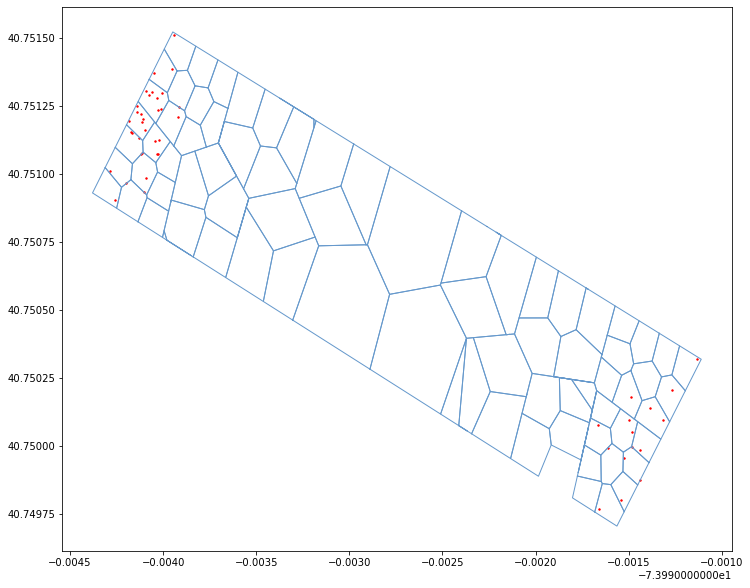

In [7]:
## split into small polys
plt.figure(figsize=(12,10))
for i in range(len(geodata_extreme.geometry)):
    
    poly = geodata_extreme.geometry[i]
    count = int(pred_single[i])
    random_pattern = random.poisson(poly, size=count).reshape(-1,2)
    
    x,y = poly.exterior.xy
    plt.plot(x,y, color='#6699cc',linewidth=1)
    plt.scatter(random_pattern[:,0], random_pattern[:,1], s=2, color='red')

### Reality

In [19]:
reality_root = '../../data-processing/taxi/extreme-data/extreme_0630_23.csv'
reality = pd.read_csv(reality_root)
points = np.array([[reality.long[i],reality.lat[i]] for i in range(len(reality))])

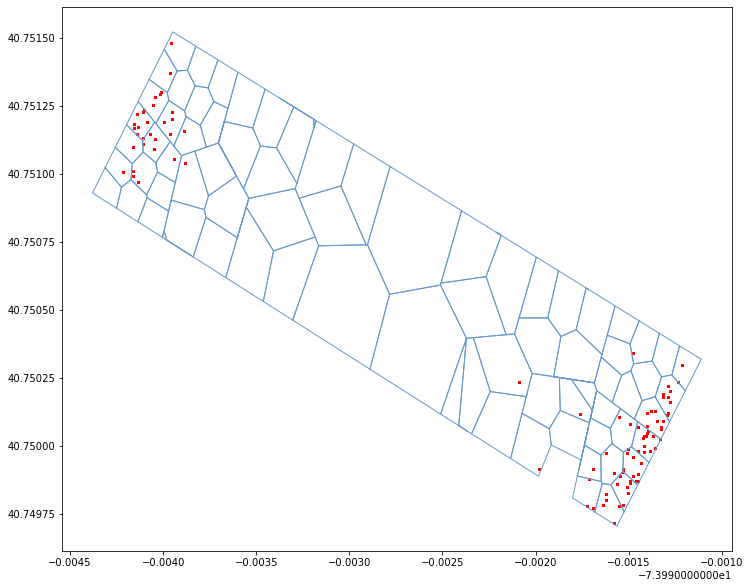

In [20]:
## split into small polys
plt.figure(figsize=(12,10))
for i in range(len(geodata_extreme.geometry)):
    
    poly = geodata_extreme.geometry[i]
    count = int(pred_single[i])
    random_pattern = random.poisson(poly, size=count).reshape(-1,2)
    
    x,y = poly.exterior.xy
    plt.plot(x,y, color='#6699cc',linewidth=1)
    plt.scatter(points[:,0], points[:,1], s=2, color='red')